In [156]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np 
import pandas as pd 
import scipy as sp
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from pykrige.ok import OrdinaryKriging

from dk_model import DeepKrigingTrainer


In [157]:
deposit_data = pd.read_csv("../Curated_data/final_dataset_1_no_0.csv", low_memory=False)


In [159]:
len(deposit_data.columns[10:])

488

In [160]:
total_columns = ['CP_Total','PO_Total', 'PY_Total']

#all covariates
covariates = total_columns[:3] + ['RQD_Pct', 'Cr_ppm'] 

In [161]:
deposit_data

,Name,X,Y,Z,Density_gcm3,RQD_Pct,Cr_ppm,CP_Total,PO_Total,PY_Total,...,phi_478,phi_479,phi_480,phi_481,phi_482,phi_483,phi_484,phi_485,phi_486,phi_487
0,KV-NME001,0.437814,0.509816,0.461455,0.400922,0.8800,0.127305,0.250,0.066667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,KV-NME001,0.438061,0.509789,0.460591,0.410138,0.8800,0.160479,0.250,0.066667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,KV-NME001,0.448174,0.508800,0.426068,0.442396,0.9900,0.128743,0.250,0.066667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,KV-NME001,0.448431,0.508777,0.425204,0.442396,0.9900,0.141317,0.375,0.133333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,KV-NME001,0.448683,0.508755,0.424340,0.442396,0.9900,0.153293,0.500,0.200000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2613,KV365,0.629186,0.001755,0.432766,0.543779,0.9235,0.078443,0.050,0.200000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2614,KV365,0.629096,0.001314,0.431988,0.539171,0.9235,0.074850,0.050,0.200000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2615,KV365,0.629011,0.000877,0.431205,0.543779,0.8584,0.076647,0.050,0.200000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2616,KV365,0.628921,0.000436,0.430427,0.525346,0.8584,0.077246,0.050,0.200000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [162]:
# Assuming deposit_data is your DataFrame
# Extract the names of the first 98 columns
phi_columns = deposit_data.columns[10:].tolist()
phi_columns[-1]


'phi_487'

In [163]:
# Function to print evaluation metrics
def print_metrics(actual, predicted, set_name, num_predictors):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    n = len(actual)
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - num_predictors - 1))

    print(f"Metrics for {set_name} set:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R^2: {r2:.4f}")
    print(f"  Adjusted R^2: {adjusted_r2:.4f}\n")


# Deepkriging covariates

In [164]:
from sklearn.model_selection import train_test_split
torch.manual_seed(42)
np.random.seed(42)
p = len(covariates) + len(phi_columns)

# Splitting data into training and testing sets
x_train, x_test, y_train, y_test, idx_train, idx_test = train_test_split(
    deposit_data[phi_columns + covariates].values,
    deposit_data['Density_gcm3'].values,
    deposit_data.index,  # Return indices for later use
    test_size=0.3, random_state=42)



# Define your neural network
model = nn.Sequential(
    nn.Linear(in_features=p, out_features=100),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.BatchNorm1d(100),
    nn.Linear(in_features=100, out_features=100),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=100, out_features=100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(in_features=100, out_features=1))

# Loss function and optimizer
mse_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Training loop
for step in range(601):
    pre = model(torch.tensor(x_train, dtype=torch.float32))
    mse = mse_loss(pre, torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32))
    cost = mse

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

# Evaluation
with torch.no_grad():
    model.eval()
    test_predictions_dk = model(torch.tensor(x_test, dtype=torch.float32)).detach().numpy().flatten()
    test_mse = mse_loss(torch.tensor(test_predictions_dk.reshape(-1, 1), dtype=torch.float32), torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32))
    print("Test MSE:", test_mse.item())


Test MSE: 0.002360763493925333


In [165]:
trainer_regular = DeepKrigingTrainer(deposit_data, covariates=['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm'], regular_nn=False, plot_errors=False)
trainer_regular.train_neural_network(mode="regular", test_size=0.3)
test_predictions_dk = trainer.test_predictions


Average Metrics Across Folds:
  Average MSE: 0.0024
  Average MAE: 0.0333
  Average adjusted R2: 0.5600
  STD MSE: 0.0000
  STD MAE: 0.0000
  STD adjusted R2: 0.0000


# NN Covariates

In [166]:
torch.manual_seed(42)
np.random.seed(42)

phi_columns = ['X','Y','Z']
p = len(covariates) + len(phi_columns)

# Perform k-fold cross-validation
from sklearn.model_selection import train_test_split

# Splitting data into training and testing sets
x_train, x_test, y_train, y_test, idx_train, idx_test = train_test_split(
    deposit_data[phi_columns + covariates].values,
    deposit_data['Density_gcm3'].values,
    deposit_data.index,  # Return indices for later use
    test_size=0.3, random_state=42)



# Define your neural network
model = nn.Sequential(
    nn.Linear(in_features=p, out_features=100),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.BatchNorm1d(100),
    nn.Linear(in_features=100, out_features=100),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=100, out_features=100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(in_features=100, out_features=1))

# Loss function and optimizer
mse_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Training loop
for step in range(601):
    pre = model(torch.tensor(x_train, dtype=torch.float32))
    mse = mse_loss(pre, torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32))
    cost = mse

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

# Evaluation
with torch.no_grad():
    model.eval()
    test_predictions_nn = model(torch.tensor(x_test, dtype=torch.float32)).detach().numpy().flatten()
    test_mse = mse_loss(torch.tensor(test_predictions_nn.reshape(-1, 1), dtype=torch.float32), torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32))
    print("Test MSE:", test_mse.item())


Test MSE: 0.0038445298559963703


In [167]:
# Create an instance of DeepKrigingTrainer
trainer = DeepKrigingTrainer(deposit_data, covariates=['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm'], regular_nn=True, plot_errors=False)

# Train the neural network (using cross-validation or regular mode)
trainer.train_neural_network(mode="regular", test_size=0.3)
test_predictions_nn = trainer.test_predictions


Average Metrics Across Folds:
  Average MSE: 0.0056
  Average MAE: 0.0479
  Average adjusted R2: 0.6147
  STD MSE: 0.0000
  STD MAE: 0.0000
  STD adjusted R2: 0.0000


# Reg kriging covariates

In [168]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

np.random.seed(42)

# Separate input features (x) and target variable (y)
y = deposit_data['Density_gcm3'].values[:, np.newaxis]  # Keep variable as the output
x = deposit_data[['X', 'Y', 'Z','CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm']].values

# Perform 70:30 train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Fit a linear regression model
regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

# Predictions from the regression model
test_predictions_rk = regression_model.predict(x_test)

# Calculate metrics
mse = mean_squared_error(y_test, test_predictions_rk)
mae = mean_absolute_error(y_test, test_predictions_rk)
sst = np.mean((y_test - np.mean(y_test)) ** 2) * len(y_test)
ssr = np.mean((test_predictions_rk - y_test) ** 2) * len(y_test)
r2 = 1 - (ssr / sst)

# Calculate adjusted R-squared
n = len(y_test)
num_predictors = x_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - num_predictors - 1))

# Print metrics
print(f"Mean Squared Error (MSE): {mse}")
#print(f"Mean Absolute Error (MAE): {mae}")
#print(f"Adjusted R-squared: {adjusted_r2}")


Mean Squared Error (MSE): 0.012730452388159527


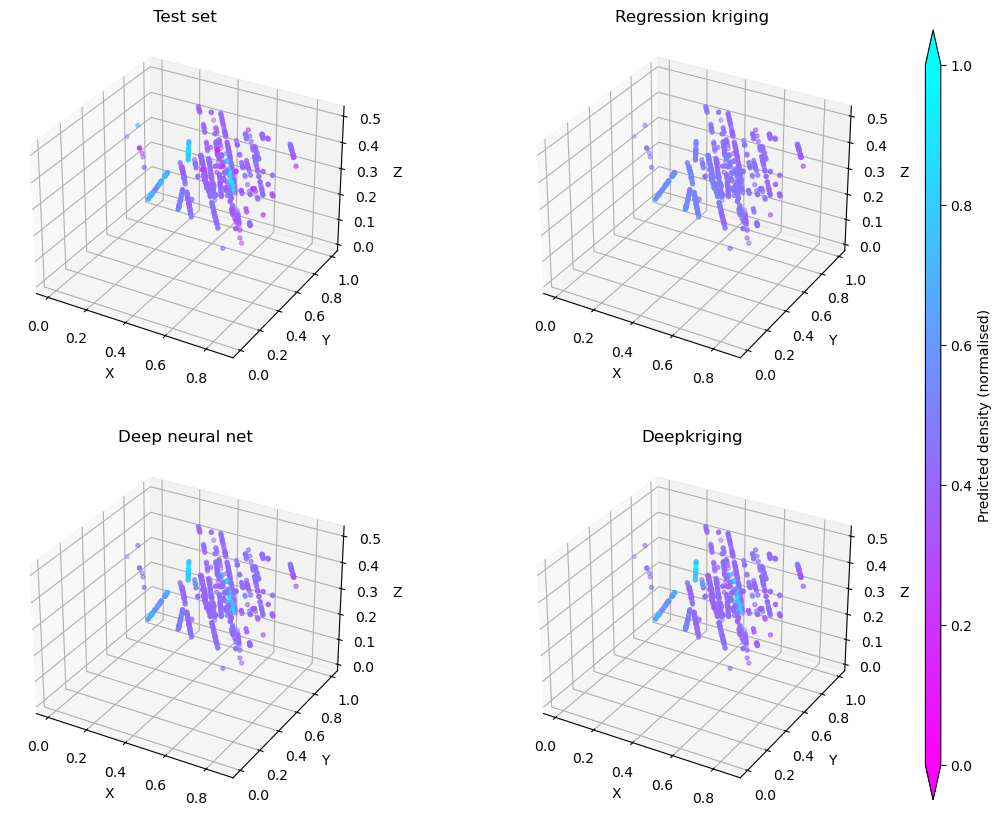

In [170]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, Normalize

train_data_xyz = deposit_data.loc[idx_train, ['X', 'Y', 'Z']].values
test_data_xyz = deposit_data.loc[idx_test, ['X', 'Y', 'Z']].values

all_predictions = np.concatenate([test_predictions_dk.ravel(), test_predictions_nn.ravel(), test_predictions_rk.ravel(), y_test.ravel()])
min_value = all_predictions.min()
max_value = all_predictions.max()

# Define custom colormap using magenta and cyan colors, like the rest of the paper
colors = [(1, 0, 1), (0, 1, 1)]  # Magenta to Cyan
cmap_name = 'MagentaCyan'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

# Create Matplotlib figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10), subplot_kw={'projection': '3d'})

# Define scatter plots for each subplot with vmin and vmax values
scatter1 = axs[1, 1].scatter(test_data_xyz[:, 0], test_data_xyz[:, 1], test_data_xyz[:, 2], c=test_predictions_dk.ravel(), cmap=custom_cmap, s=8, vmin=min_value, vmax=max_value)
scatter2 = axs[1, 0].scatter(test_data_xyz[:, 0], test_data_xyz[:, 1], test_data_xyz[:, 2], c=test_predictions_nn.ravel(), cmap=custom_cmap, s=8, vmin=min_value, vmax=max_value)
scatter3 = axs[0, 1].scatter(test_data_xyz[:, 0], test_data_xyz[:, 1], test_data_xyz[:, 2], c=test_predictions_rk.ravel(), cmap=custom_cmap, s=8, vmin=min_value, vmax=max_value)
scatter4 = axs[0, 0].scatter(test_data_xyz[:, 0], test_data_xyz[:, 1], test_data_xyz[:, 2], c=y_test.ravel(), cmap=custom_cmap, s=8, vmin=min_value, vmax=max_value)

# Set titles for each subplot
axs[1, 1].set_title('Deepkriging')
axs[1, 0].set_title('Deep neural net')
axs[0, 1].set_title('Regression kriging')
axs[0, 0].set_title('Test set')

# Set common labels for all subplots
for ax in axs.flat:
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

# Create a single colorbar
norm = Normalize(vmin=min_value, vmax=max_value)
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])  # this line is necessary for ScalarMappable to work properly
cbar = fig.colorbar(sm, ax=axs, pad=0.05, aspect=50, extend='both')
cbar.set_label('Predicted density (normalised)')

#plt.tight_layout()
plt.savefig('combined_plots_with_common_colorbar_MagentaCyan_inverted.png')  # Save the plot as PNG
plt.show()


In [ ]:
import plotly.graph_objects as go

# Extract relevant rows from deposit_data for the test set
test_data_xyz = deposit_data.loc[idx_test, ['X', 'Y', 'Z']].values

# Determine the color range based on all sets of predictions
min_value = min(test_predictions_nn.min(), test_predictions_dk.min(), test_predictions_rk.min())
max_value = max(test_predictions_nn.max(), test_predictions_dk.max(), test_predictions_rk.max())

# Create subplot figure
fig = go.Figure()

# Define the first subplot (left side)
fig.add_trace(go.Scatter3d(
    x=test_data_xyz[:, 0],  
    y=test_data_xyz[:, 1],  
    z=test_data_xyz[:, 2],  
    mode='markers',
    marker=dict(
        size=4,
        color=test_predictions_dk.ravel(),  # Color based on predictions
        colorscale='speed',    
        cmin=min_value,
        cmax=max_value,
        opacity=0.8,
        colorbar=dict(title='Predicted Values')
    ),
    showlegend=False,
    scene='scene1',  # Use scene1 for the first subplot
))

# Define the second subplot (middle)
fig.add_trace(go.Scatter3d(
    x=test_data_xyz[:, 0],  
    y=test_data_xyz[:, 1],  
    z=test_data_xyz[:, 2],  
    mode='markers',
    marker=dict(
        size=4,
        color=test_predictions_nn.ravel(),  # Color based on predictions
        colorscale='speed',   
        cmin=min_value,
        cmax=max_value,
        opacity=0.8,
        colorbar=dict(title='Predicted Values')
    ),
    showlegend=False,
    scene='scene2'  # Use scene2 for the second subplot
))

# Define the third subplot (right side)
fig.add_trace(go.Scatter3d(
    x=test_data_xyz[:, 0], 
    y=test_data_xyz[:, 1], 
    z=test_data_xyz[:, 2],  
    mode='markers',
    marker=dict(
        size=4,
        color=test_predictions_rk.ravel(),  # Color based on predictions
        colorscale='speed',    
        cmin=min_value,
        cmax=max_value,
        opacity=0.8,
        colorbar=dict(title='Predicted Values')
    ),
    showlegend=False,
    scene='scene3'  # Use scene3 for the third subplot
))

fig.update_layout(
    scene1=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        camera_eye=dict(x=-1.25, y=1.25, z=1)
    ),
    scene2=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        camera_eye=dict(x=-1.25, y=1.25, z=1)
    ),
    scene3=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        camera_eye=dict(x=-1.25, y=1.25, z=1)
    ),
    margin=dict(l=0, r=0, b=0, t=50),
    title={
        'text': "Deepkriging                                                                            Deep neural net                                                                 Regression kriging",
        'x': 0.1  # Center the titles horizontally
    }
)
fig.write_html("3d_plot_model_comparisons.html")

# Show plot
fig.show()


In [ ]:
import plotly.graph_objects as go

# Extract relevant rows from deposit_data for the test set
test_data_xyz = deposit_data.loc[idx_test, ['X', 'Y', 'Z']].values

# Determine the color range based on all sets of predictions
min_value = min((test_predictions_dk.ravel() - test_predictions_nn.ravel()).min(), (test_predictions_nn.ravel() - test_predictions_rk.ravel()).min(), (test_predictions_dk.ravel() - test_predictions_rk.ravel()).min())
max_value = max((test_predictions_dk.ravel() - test_predictions_nn.ravel()).max(), (test_predictions_nn.ravel() - test_predictions_rk.ravel()).max(), (test_predictions_dk.ravel() - test_predictions_rk.ravel()).max())

# Calculate the absolute maximum value to ensure symmetry around 0
abs_max_value = max(abs(min_value), abs(max_value))

# Create subplot figure
fig = go.Figure()

# Define the first subplot (left side)
fig.add_trace(go.Scatter3d(
    x=test_data_xyz[:, 0],  # X coordinates
    y=test_data_xyz[:, 1],  # Y coordinates
    z=test_data_xyz[:, 2],  # Z coordinates
    mode='markers',
    marker=dict(
        size=4,
        color=test_predictions_dk.ravel() - test_predictions_nn.ravel(),  # Color based on predictions
        colorscale='RdBu_r',    # Color scale
        cmin=-abs_max_value,    # Set the minimum value to -abs_max_value
        cmax=abs_max_value,     # Set the maximum value to abs_max_value
        opacity=0.8,
        colorbar=dict(title='Predicted Values')
    ),
    showlegend=False,
    scene='scene1',  # Use scene1 for the first subplot
))

# Define the second subplot (middle)
fig.add_trace(go.Scatter3d(
    x=test_data_xyz[:, 0],  # X coordinates
    y=test_data_xyz[:, 1],  # Y coordinates
    z=test_data_xyz[:, 2],  # Z coordinates
    mode='markers',
    marker=dict(
        size=4,
        color=test_predictions_nn.ravel() - test_predictions_rk.ravel(),  # Color based on predictions
        colorscale='RdBu_r',    # Color scale
        cmin=-abs_max_value,    # Set the minimum value to -abs_max_value
        cmax=abs_max_value,     # Set the maximum value to abs_max_value
        opacity=0.8,
        colorbar=dict(title='Predicted Values')
    ),
    showlegend=False,
    scene='scene2'  # Use scene2 for the second subplot
))

# Define the third subplot (right side)
fig.add_trace(go.Scatter3d(
    x=test_data_xyz[:, 0],  # X coordinates
    y=test_data_xyz[:, 1],  # Y coordinates
    z=test_data_xyz[:, 2],  # Z coordinates
    mode='markers',
    marker=dict(
        size=4,
        color= test_predictions_dk.ravel() - test_predictions_rk.ravel(),  # Color based on predictions
        colorscale='RdBu_r',    # Color scale
        cmin=-abs_max_value,    # Set the minimum value to -abs_max_value
        cmax=abs_max_value,     # Set the maximum value to abs_max_value
        opacity=0.8,
        colorbar=dict(title='Predicted Values')
    ),
    showlegend=False,
    scene='scene3'  # Use scene3 for the third subplot
))

# Update layout for all subplots
fig.update_layout(
    scene1=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        camera_eye=dict(x=-1.25, y=1.25, z=1)
    ),
    scene2=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        camera_eye=dict(x=-1.25, y=1.25, z=1)
    ),
    scene3=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        camera_eye=dict(x=-1.25, y=1.25, z=1)
    ),
    margin=dict(l=0, r=0, b=0, t=50),
    title={
        'text': "Deepkriging-DNN                                                       Deep neural net - Regression kriging                                            Deepkriging - Regression kriging",
        'x': 0.1  # Center the titles horizontally
    }
)

# Show plot
fig.show()
